In [162]:
import os
import torch
import librosa
import numpy as np
import torch.nn as nn
import librosa.display
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import classification_report, confusion_matrix

In [163]:
audio_path = 'train/'
students_num = ["029", "033", "039", "045", "049", "068", "914", "918", "919", "934", "970"]
orders_num = ["Takeoff", "Landing", "Advance", "Retreat", "Rise"]
repeat_num = ['1', '2', '3', '4']
number_of_mfcc_features = 13
orders_dic = {
    'Takeoff': 0,
    'Landing': 1,
    'Advance': 2,
    'Retreat': 3,
    'Rise': 4
}
batch_size = 8

# 数据增强

In [164]:
#添加噪音
def add_noise(data, noise_factor = 0.015):
    noise = noise_factor * np.random.randn(len(data))
    data = data + noise
    return data
#延时
def time_stretch(data, rate = 0.8):   #0.8倍速慢放
    return librosa.effects.time_stretch(data, rate=rate)
#时移
def time_shift(data, sr, shift_time = 0.2):      #shift_time最大时移长度,单位 秒
    shift = np.random.randint(-shift_time * sr,shift_time * sr)
    #shift为负值，代表左移，为正值代表右移
    return np.roll(data,shift)
#增高音调
def pitch(data, sr, pitch_factor = 0.5):
    n_steps = pitch_factor * 12     #将音高偏移量pitch_factor转换为半音步数n_steps
    #12是参数bins_per_octave的默认值，表示每个八度12个半音
    return librosa.effects.pitch_shift(data,sr=sr,n_steps=n_steps)

# MFCC特征提取

In [165]:
def mfcc_extraction(path, students_num, orders_num, repeat_num):
    labels = []
    mfcc_features = []
    for stu_num in students_num:
        for index, order in enumerate(orders_num):
            for repeat in repeat_num:
                file_path = path + stu_num + '_' + str(index+1) + '_' + repeat + ".wav"
                if os.path.exists(file_path):
                    x, sr = librosa.load(file_path)
                    x = librosa.effects.preemphasis(x)  # 预加重处理
                    #数据增强
                    x1 = add_noise(x)
                    x2 = time_stretch(x)
                    x3 = time_shift(x, sr)
                    x4 = pitch(x, sr)
                    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=number_of_mfcc_features).T
                    mfcc_features.append(mfccs)
                    labels.append(order)
                    mfccs1 = librosa.feature.mfcc(y=x1, sr=sr, n_mfcc=number_of_mfcc_features).T
                    mfcc_features.append(mfccs1)
                    labels.append(order)
                    mfccs2 = librosa.feature.mfcc(y=x2, sr=sr, n_mfcc=number_of_mfcc_features).T
                    mfcc_features.append(mfccs2)
                    labels.append(order)
                    mfccs3 = librosa.feature.mfcc(y=x3, sr=sr, n_mfcc=number_of_mfcc_features).T
                    mfcc_features.append(mfccs3)
                    labels.append(order)
                    mfccs4 = librosa.feature.mfcc(y=x4, sr=sr, n_mfcc=number_of_mfcc_features).T
                    mfcc_features.append(mfccs4)
                    labels.append(order)
                else:
                    pass
    return mfcc_features, labels

In [166]:
mfcc_features_and_labels = mfcc_extraction(audio_path, students_num, orders_num, repeat_num)
mfcc_features, mfcc_labels = mfcc_features_and_labels
mfcc_labels = np.array(mfcc_labels)
'''for feature in mfcc_features:
    print(f'(num_frame,num_coefficients):{feature.shape}')'''

"for feature in mfcc_features:\n    print(f'(num_frame,num_coefficients):{feature.shape}')"

# 统一特征向量长度
    特征向量长度不一，短的部分充0，使长度统一

In [167]:
#mfcc_features = np.array(mfcc_features)
def zero_pad(features):

    new_spoken_train = []
    max_shape = 0
    for x in features:
        all_shapes = x.shape[0]
        if all_shapes > max_shape:
            max_shape = all_shapes

    for x in features:
        difference = max_shape-x.shape[0]
        zero_padded = np.pad(x,((0,difference),(0,0)), "constant")
        new_spoken_train.append(zero_padded)

    new_spoken_train = np.array(new_spoken_train)

    return new_spoken_train

mfcc_features = zero_pad(mfcc_features)
print(mfcc_features.shape)

(560, 108, 13)


# 数据标准化

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
flatten_mfcc_features = np.reshape(mfcc_features,(mfcc_features.shape[0],108 * 13))
print(flatten_mfcc_features.shape)

#标准化
'''
data = flatten_mfcc_features
scaler = StandardScaler()
mfcc_features = scaler.fit_transform(data)
'''

#鲁棒缩放，减小异常数据的影响
data = flatten_mfcc_features
scaler = RobustScaler()
mfcc_features = scaler.fit_transform(data)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
new_mfcc_features,  mfcc_labels = ros.fit_resample(mfcc_features,  mfcc_labels)

'''
dictionary = {}
for i in mfcc_labels:
    dictionary[i] = dictionary.get(i,0) + 1
print(dictionary)
#>>>{'Takeoff': 120, 'Landing': 120, 'Advance': 120, 'Retreat': 120, 'Rise': 120}
'''

new_mfcc_features = np.reshape(new_mfcc_features,(new_mfcc_features.shape[0],108, 13))
print(new_mfcc_features.shape)


(560, 1404)
(600, 108, 13)


# 划分训练集、测试集

In [169]:
from sklearn.model_selection import train_test_split
mfcc_labels = [orders_dic[label] for label in mfcc_labels]
X_train, X_test, y_train, y_test = train_test_split(new_mfcc_features, mfcc_labels, test_size=0.30,
                                                    random_state=42, stratify = mfcc_labels, shuffle= True)

# 数据加载

In [170]:
class MFCC_DataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label
    
#整合特征数据和标签
train_dataset = MFCC_DataSet(X_train, y_train)
test_dataset = MFCC_DataSet(X_test, y_test)
#乱序的数据加载器
train_dl = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

    
#遍历数据加载器元素
#enumerate(data,start),start为输出的索引起始值，默认为0
'''
for i,batch in enumerate(train_dl,1):
    print(f'batch:{i}:','x:',batch[0],
          '\n     y:',batch[1])
    #输出特征数据张量大小
    print(batch[0].shape)
    #输出特征数据张量大小
    print(batch[1].shape)
'''

"\nfor i,batch in enumerate(train_dl,1):\n    print(f'batch:{i}:','x:',batch[0],\n          '\n     y:',batch[1])\n    #输出特征数据张量大小\n    print(batch[0].shape)\n    #输出特征数据张量大小\n    print(batch[1].shape)\n"

# 构建神经网络模型

In [171]:
class MFCC_CNN(nn.Module):
    def __init__(self):
        super(MFCC_CNN, self).__init__()
        #Conv2d采用NCHW格式，N代表批数据图像数量（batch_size），C代表通道数，H、W分别代表图像高和宽
        #不考虑批数据维度时，第一个维度为通道数
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)      #添加 Dropout 层
        
        ''' # 计算 fc1 的输入维度
        num_frame = 108  num_coefficients = 13
        conv_out_channels = 64
        pool1_out_frames = (num_frames - 2) // 2 + 1        #54
        pool1_out_num_coefficients = (num_coefficients - 2) // 2 + 1        #6
        
        pool2_out_frames = (pool1_out_frames - 2) // 2 + 1      #27
        pool2_out_num_coefficients = (pool1_out_num_coefficients - 2) // 2 + 1      #3  '''
        
        self.fc1 = nn.Linear(64 * 27 * 3, 2048)
        self.fc2 = nn.Linear(2048, 5)
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # 展平
        x = self.dropout(x)     #应用Dropout层
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.softmax(x)
        return x


# 训练网络模型

In [172]:
#实例化
model = MFCC_CNN()
# 定义优化器和损失函数
criterion = nn.CrossEntropyLoss()
#CrossEntropyLoss损失函数已经包含了softmax激活函数
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)        #Adam优化器


#开始训练
def train(model,num_epochs,train_dl,test_dl):
    #存储历史数据
    loss_hist_train = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    loss_hist_test = [0]*num_epochs
    accuracy_hist_test = [0]*num_epochs
    
    best_acc = 0.0
    best_epoch = 0

    # 存储每轮的预测标签和实际标签
    conf_pred_all_epochs = []
    conf_true_all_epochs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_corrects_train = 0  # 用于记录每个 epoch 的训练准确度
        running_loss_train = 0.0    # 用于记录每个 epoch 的训练损失
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.float()
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            optimizer.zero_grad()       #梯度归零
            loss.backward()             #反向传输参数梯度值
            optimizer.step()            #梯度下降执行参数更新   
            '''
            .item()用于张量只有一个元素时，将改张量的具体元素值转化为 int 或 float 型并返回
            y_batch.szie(0) 等值于 batch_size，batch_size 影响加载 train_dl 时几个数据为一批 
            相乘意为计算一个 epoch 内的损失之和
            '''
            '''
            对于一个维度为(d0,d1) 的矩阵来说
            dim=1表示求每一行中最大数的在该行中的列号，最后得到的就是一个维度为(d0,1) 的二维矩阵，最终列这一维度大小为1就要消失了，最终结果变成一维张量(d0)；
            dim=0表示求每一列中最大数的在该列中的行号，最后得到的就是一个维度为(1,d1) 的二维矩阵，结果行这一维度大小为1就要消失了，最终结果变成一维张量(d1)。
            '''
            running_loss_train += loss.item() * x_batch.size(0)
            is_correct = (torch.argmax(pred,dim=1) == y_batch)
            running_corrects_train += is_correct.sum().item()
            
        loss_hist_train[epoch] = running_loss_train/ len(train_dl.dataset)
        accuracy_hist_train[epoch] =running_corrects_train / len(train_dl.dataset)
        #len(train_dl) 返回的是数据加载器（DataLoader）中批次数量（batch_size）
        #len(train_dl.dataset) 返回的是数据集（Dataset）中的样本数量
        
        model.eval()
        
        running_corrects_test = 0  # 用于记录每个 epoch 的训练准确度
        running_loss_test = 0.0    # 用于记录每个 epoch 的训练损失
        conf_pred = []
        conf_true = []
       
        #torch.no_grad()为一个上下文管理器，在之后的进程里不会进行梯度计算，减少内存使用
        with torch.no_grad():
            for x_batch, y_batch in test_dl:
                x_batch = x_batch.float()
                pred = model(x_batch)
                loss = criterion(pred, y_batch)
               
                running_loss_test += loss.item() * x_batch.size(0)  
                is_correct = (torch.argmax(pred,dim=1) == y_batch)
                running_corrects_test += is_correct.sum().item()
                
                # 将当前 batch 的预测和实际标签添加到列表中
                # .extend()是将数组元素每个都添加,.append()是将数组当作一个整体元素添加
                conf_pred.extend(torch.argmax(pred, dim=1).numpy())
                conf_true.extend(y_batch.numpy())
                
        loss_hist_test[epoch] = running_loss_test / len(test_dl.dataset)
        accuracy_hist_test[epoch] =running_corrects_test / len(test_dl.dataset)
        
        # 保存每轮的预测标签和实际标签
        conf_pred_all_epochs.append(conf_pred)
        conf_true_all_epochs.append(conf_true)
        
        # 记录最好的数据和模型参数
        if accuracy_hist_test[epoch] > best_acc:
            best_acc = accuracy_hist_test[epoch]
            best_epoch = epoch
            
        print(f'Epoch{epoch+1} '
              f'accuracy:{accuracy_hist_train[epoch]:.4f} '
              f'test_accuracy:{accuracy_hist_test[epoch]:.4f} ')  
        
    print(f'best_accuracy:{best_acc:.4f} ')
    return loss_hist_train, loss_hist_test, accuracy_hist_train, accuracy_hist_test,conf_pred_all_epochs,conf_true_all_epochs,best_epoch
      

# 运行结果

In [173]:
torch.manual_seed(1)
num_epochs = 50
loss_hist_train, loss_hist_test, accuracy_hist_train, accuracy_hist_test, conf_pred_all_epochs, conf_true_all_epochs,best_epoch = train(model,num_epochs,train_dl,test_dl)

Epoch1 accuracy:0.1881 test_accuracy:0.2333 
Epoch2 accuracy:0.2405 test_accuracy:0.2111 
Epoch3 accuracy:0.2381 test_accuracy:0.2389 
Epoch4 accuracy:0.2405 test_accuracy:0.2500 
Epoch5 accuracy:0.2643 test_accuracy:0.2111 
Epoch6 accuracy:0.3071 test_accuracy:0.3278 
Epoch7 accuracy:0.3929 test_accuracy:0.4556 
Epoch8 accuracy:0.4643 test_accuracy:0.3778 
Epoch9 accuracy:0.5143 test_accuracy:0.4278 
Epoch10 accuracy:0.5167 test_accuracy:0.5111 
Epoch11 accuracy:0.5881 test_accuracy:0.5333 
Epoch12 accuracy:0.5905 test_accuracy:0.5222 
Epoch13 accuracy:0.6524 test_accuracy:0.5278 
Epoch14 accuracy:0.6738 test_accuracy:0.5833 
Epoch15 accuracy:0.6429 test_accuracy:0.5333 
Epoch16 accuracy:0.6810 test_accuracy:0.5278 
Epoch17 accuracy:0.6810 test_accuracy:0.6056 
Epoch18 accuracy:0.7357 test_accuracy:0.6222 
Epoch19 accuracy:0.7524 test_accuracy:0.6167 
Epoch20 accuracy:0.7262 test_accuracy:0.5833 
Epoch21 accuracy:0.7643 test_accuracy:0.5833 
Epoch22 accuracy:0.7786 test_accuracy:0.605

# 画 Loss 和 Accuracy 图

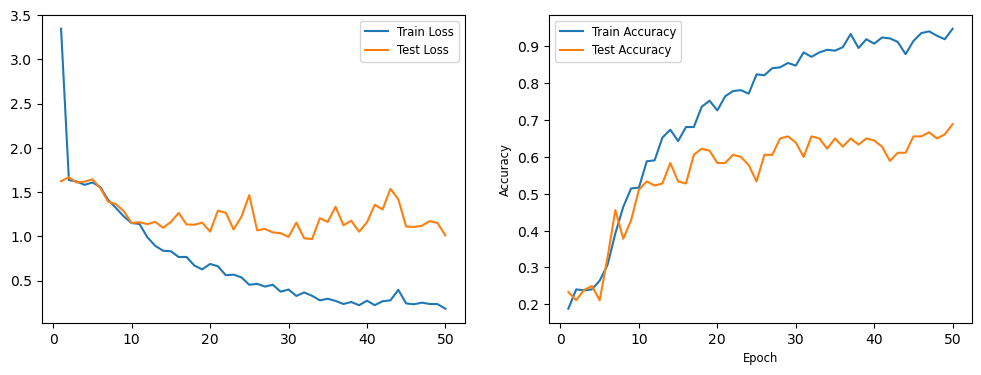

In [174]:
x_arr = np.arange(len(loss_hist_train)) + 1
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(121)
ax.plot(x_arr, loss_hist_train, label='Train Loss')
ax.plot(x_arr, loss_hist_test, label='Test Loss')
ax.legend(fontsize = 'small')
ax = fig.add_subplot(122)
ax.plot(x_arr, accuracy_hist_train, label='Train Accuracy')
ax.plot(x_arr, accuracy_hist_test, label='Test Accuracy')
ax.legend(fontsize = 'small')
ax.set_xlabel('Epoch', fontsize = 'small')
ax.set_ylabel('Accuracy', fontsize = 'small')
plt.show()


# 训练最好一轮的混淆矩阵

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        36
           1       0.60      0.75      0.67        36
           2       0.59      0.61      0.60        36
           3       0.77      0.75      0.76        36
           4       0.83      0.69      0.76        36

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180



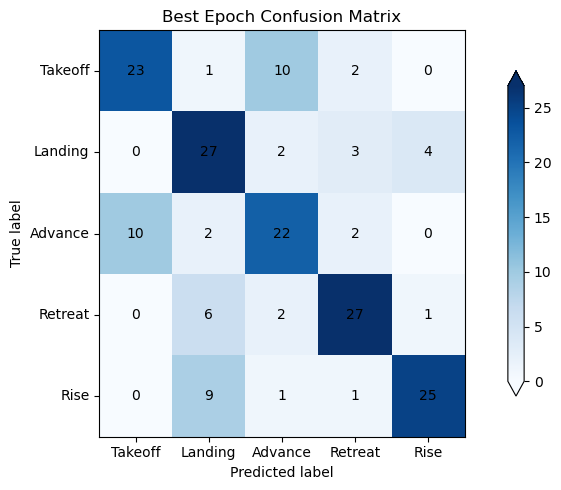

In [177]:
best_conf_pred = conf_pred_all_epochs[best_epoch]
best_conf_true = conf_true_all_epochs[best_epoch]

# 混淆矩阵
confmat_best = confusion_matrix(y_true=best_conf_true, y_pred=best_conf_pred)
print(classification_report(best_conf_true, best_conf_pred))

fig, ax = plt.subplots(figsize=(6, 5))
plt.gcf().subplots_adjust(left=0.25,right=0.95,bottom=0.19,top=0.8) #设置图像边界
plt.imshow(confmat_best,cmap='Blues',aspect='auto')
ax.xaxis.set_ticks_position('bottom')
# 填入数据
for i in range(confmat_best.shape[0]):
    for j in range(confmat_best.shape[1]):
        ax.text(x=j,y=i,s=confmat_best[i,j],
                va='center',ha='center')

plt.title('Best Epoch Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(orders_num)),labels=orders_num,horizontalalignment='center')
plt.yticks(ticks=np.arange(len(orders_num)),labels=orders_num,verticalalignment='center')
plt.tick_params(axis='both',which='minor',color='blue',pad=5,labelsize=4,direction='out')
plt.colorbar(pad=0.09,orientation='vertical',extend='both',shrink=0.8,location='right')

plt.tight_layout()
plt.show()

# 所有训练的混淆矩阵

              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1800
           1       0.53      0.56      0.55      1800
           2       0.52      0.46      0.49      1800
           3       0.61      0.61      0.61      1800
           4       0.61      0.63      0.62      1800

    accuracy                           0.56      9000
   macro avg       0.55      0.56      0.55      9000
weighted avg       0.55      0.56      0.55      9000



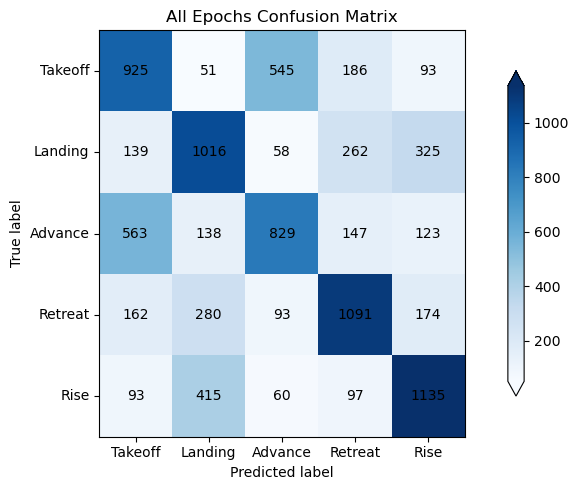

In [178]:
all_conf_pred = []
all_conf_true = []
for epoch in range(num_epochs):
    all_conf_pred.extend(conf_pred_all_epochs[epoch])
    all_conf_true.extend(conf_true_all_epochs[epoch])

# 混淆矩阵
confmat_all = confusion_matrix(y_true=all_conf_true, y_pred=all_conf_pred)
print(classification_report(all_conf_true, all_conf_pred))


fig, ax = plt.subplots(figsize=(6, 5))
plt.gcf().subplots_adjust(left=0.25,right=0.95,bottom=0.19,top=0.8) #设置图像边界
plt.imshow(confmat_all,cmap='Blues',aspect='auto')
ax.xaxis.set_ticks_position('bottom')
# 填入数据
for i in range(confmat_all.shape[0]):
    for j in range(confmat_all.shape[1]):
        ax.text(x=j,y=i,s=confmat_all[i,j],
                va='center',ha='center')

plt.title('All Epochs Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(orders_num)),labels=orders_num,horizontalalignment='center')
plt.yticks(ticks=np.arange(len(orders_num)),labels=orders_num,verticalalignment='center')
plt.tick_params(axis='both',which='minor',color='blue',pad=5,labelsize=4,direction='out')
plt.colorbar(pad=0.09,orientation='vertical',extend='both',shrink=0.8,location='right')

plt.tight_layout()
plt.show()
